---
title: "The Spaceship Titanic with LightGBM"
author: "Daniel Smith"
date: "2023-11-23"
categories: [Python, ML, Pandas, Seaborn, LightGBM]
title-block-banner: false
jupyter: python3
description: "A LightGBM classifier is trained with hyperparameters tuned using a random search to achieve >80% classification accuracy on the Spaceship Titanic dataset."
---

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from lightgbm import LGBMClassifier

In [1]:
import sys
print("Python version:")
print(sys.version)

Python version:
3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]


**Table of contents**<a id='toc0_'></a>    
1. [Data imports and exploration](#toc1_)    
2. [Missing values and feature engineering](#toc2_)    
2.1. [Filling `HomePlanet`, `Destination` and `VIP`](#toc2_1_)    
2.2. [Filling `Age` and the expenditure features](#toc2_2_)    
2.3. [New features - `AgeGroup`, `CabinSide` and `GroupSize`](#toc2_3_)    
2.4. [Finishing preprocessing - dropping features and splitting into train and test sets](#toc2_4_)    
3. [Tuning a `LGBMClassifier` with `RandomizedSearchCV`](#toc3_)    
4. [Fitting the best `LGBMClassifier` to the train set](#toc4_)    
5. [Using the trained model to predict on the test set](#toc5_)    
6. [Further Directions](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=5
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Data imports and exploration](#toc0_)

We use the [Spaceship Titanic dataset from Kaggle](https://www.kaggle.com/competitions/spaceship-titanic), designed as a lighthearted, fictional reimagining of the famous (infamous) titanic dataset. The goal is to predict if passengers on the Spaceship Titanic were transported into an alternate dimension by a collision with a spacetime anamoly, based upon known data.

The data is provided in two files, `train.csv` and `test.csv`. The training data `train.csv` has all of the following features, while the test data `test.csv` has all of the following features minus the target `Transported` feature.


> * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
> * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
> * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
> * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
> * **Destination** - The planet the passenger will be debarking to.
> * **Age** - The age of the passenger.
> * **VIP** - Whether the passenger has paid for special VIP service during the voyage.
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
> * **Name** - The first and last names of the passenger.
> * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


The aim of the competition is to train a model on the training data and use it to predict labels for the test data. Kaggle then assigns a score to the submission by comparing the submitted labels with the known, hidden values. 

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Combine train and test sets into a single dataframe for convenience
data = pd.concat([df_train,df_test],axis=0)
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [4]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


<Axes: >

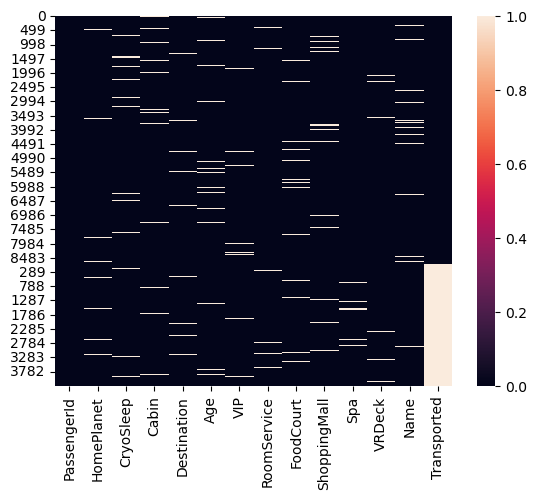

In [6]:
sns.heatmap(data.isnull())

In [7]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
df_test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

As we can see, all features other than `PassengerId` and `Transported` have a non-zero number of null values for both the train and test sets. Deciding how to fill these null values is a crucial step in contructing a solution. Our programme is quite simple, but more complicated methods to fill can result in better performing models.

Text(0.5, 1.0, 'Transported distribution in df_train')

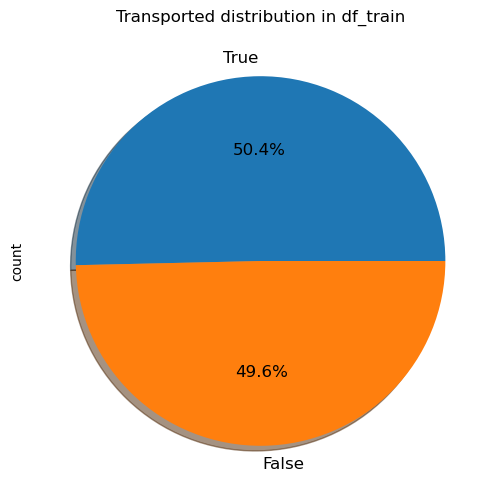

In [9]:
plt.figure(figsize=(6,6))
df_train['Transported'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, textprops={'fontsize':12}).set_title("Transported distribution in df_train")

The above figure shows that the label is very well balanced in the train set, with roughly half of all passengers transported.

Text(0.5, 0, 'Age (years)')

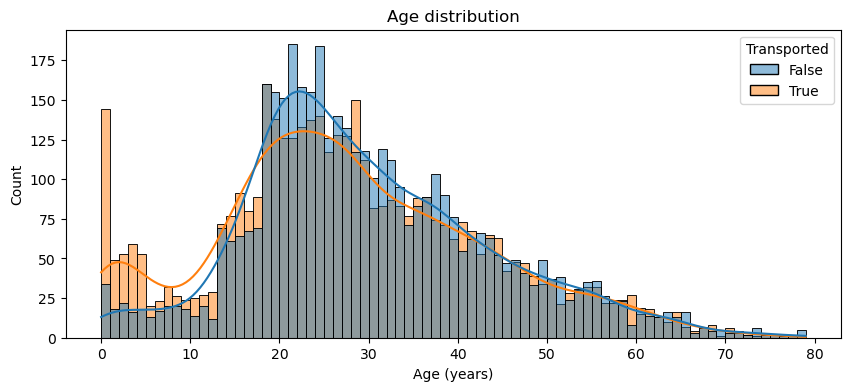

In [10]:
plt.figure(figsize=(10,4))
sns.histplot(data=df_train, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('Age distribution')
plt.xlabel('Age (years)')

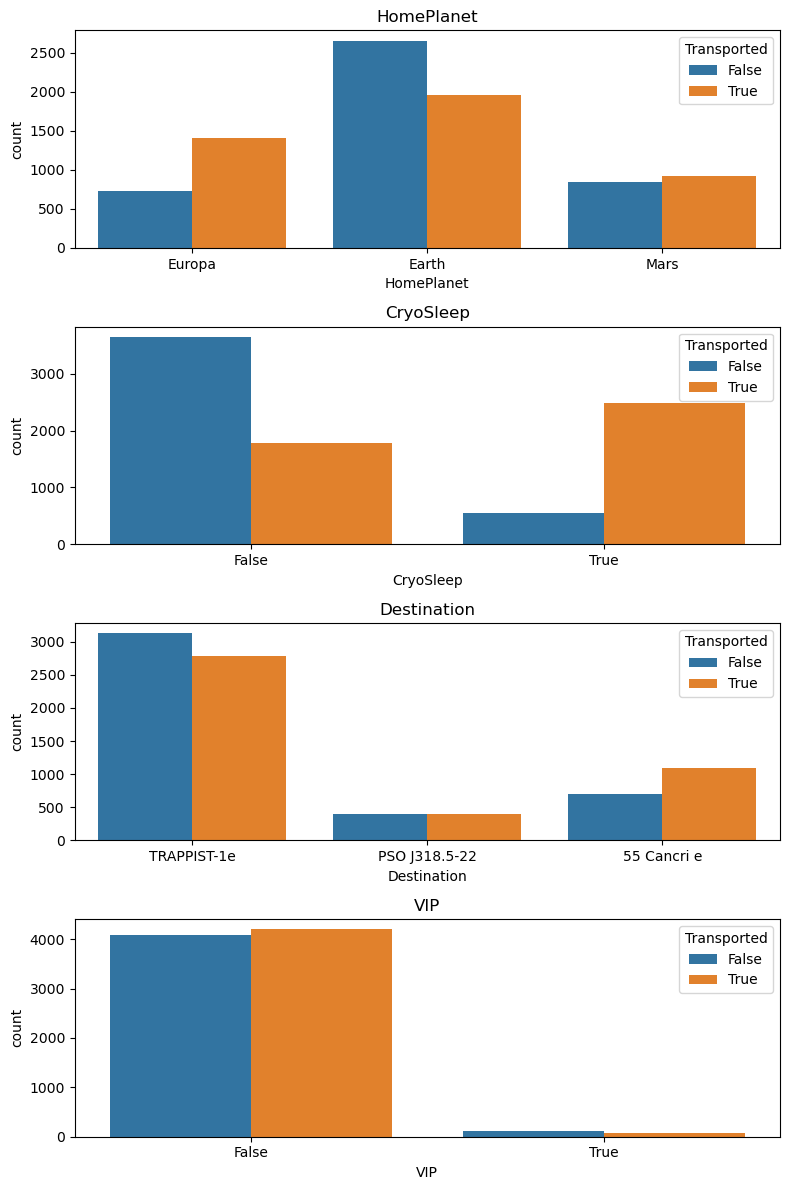

In [11]:
fig = plt.figure(figsize=(8,12))
for i, var_name in enumerate(['HomePlanet', 'CryoSleep', 'Destination', 'VIP']):
    ax = fig.add_subplot(4,1,i+1)
    sns.countplot(data=df_train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()

# 2. <a id='toc2_'></a>[Missing values and feature engineering](#toc0_)

In [12]:
Expenses_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

Fill the null values in the `Expenses_features` with 0 for the passengers in cryosleep

In [13]:
data.loc[:,Expenses_features] = data.apply(lambda x: 0 if x.CryoSleep == True else x, axis=1)

Create a new feature `TotalExpenditure`, just the sum of the `Expenses_features`

In [14]:
data['TotalExpenditure'] = data.loc[:,Expenses_features].sum(axis=1)

Fill the null values in `CryoSleep` with `True` if `TotalExpenditure == 0`. This of course is not necessarily true - a passenger doesn't have to be in cryostatis to spend nothing. However, it seems a reasonable assumption for the purposes of filling missing values. Fill the other null values in `CryoSleep` with `False`.

In [15]:
data.loc[:,['CryoSleep']] = data.apply(lambda x: True if x.TotalExpenditure == 0 and pd.isna(x.CryoSleep) else x, axis=1)
data['CryoSleep'] = data['CryoSleep'].fillna(False)

## 2.1. <a id='toc2_1_'></a>[Filling `HomePlanet`, `Destination` and `VIP`](#toc0_)

In [16]:
df_train['HomePlanet'].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

In [17]:
df_test['HomePlanet'].value_counts()

HomePlanet
Earth     2263
Europa    1002
Mars       925
Name: count, dtype: int64

The mode for `HomePlanet` for both the train and test sets is "Earth", so we use this to fill the null values

In [18]:
data['HomePlanet'] = data['HomePlanet'].fillna('Earth')

In [19]:
df_train['Destination'].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [20]:
df_test['Destination'].value_counts()

Destination
TRAPPIST-1e      2956
55 Cancri e       841
PSO J318.5-22     388
Name: count, dtype: int64

The mode for `Destination` for both the train and test sets is "TRAPPIST-1e", so we use this to fill the null values

In [21]:
data['Destination'] = data['Destination'].fillna('TRAPPIST-1e')

In [22]:
df_train['VIP'].value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

In [23]:
df_test['VIP'].value_counts()

VIP
False    4110
True       74
Name: count, dtype: int64

In [24]:
data['VIP'] = data['VIP'].fillna(False)

In [25]:
data.isna().sum()

PassengerId            0
HomePlanet             0
CryoSleep              0
Cabin                299
Destination            0
Age                  270
VIP                    0
RoomService          170
FoodCourt            180
ShoppingMall         175
Spa                  177
VRDeck               177
Name                 294
Transported         4277
TotalExpenditure       0
dtype: int64

## 2.2. <a id='toc2_2_'></a>[Filling `Age` and the expenditure features](#toc0_)

To fill the remaining null values in `Age` and `Expenses_features` we will use the median, to reduce the influence of outliers. This requires seperating `data` back into constituent train and test sets, to avoid data leakage.

In [26]:
train = data[:len(df_train)]
test = data[len(df_train):].drop('Transported', axis=1)

In [27]:
print(len(train) == len(df_train))

True


In [28]:
train.loc[:, 'Age'] = train['Age'].fillna(train['Age'].median())
test.loc[:, 'Age'] = test['Age'].fillna(test['Age'].median())

In [29]:
train.loc[:,Expenses_features] = train[Expenses_features].fillna(train[Expenses_features].median())
test.loc[:,Expenses_features] = test[Expenses_features].fillna(test[Expenses_features].median())

In [30]:
print('Remaining null values in train:\n')
print(train.isna().sum())
print('\nRemaining null values in test:\n')
print(test.isna().sum())

Remaining null values in train:

PassengerId           0
HomePlanet            0
CryoSleep             0
Cabin               199
Destination           0
Age                   0
VIP                   0
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                200
Transported           0
TotalExpenditure      0
dtype: int64

Remaining null values in test:

PassengerId           0
HomePlanet            0
CryoSleep             0
Cabin               100
Destination           0
Age                   0
VIP                   0
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                 94
TotalExpenditure      0
dtype: int64


Redefine `data` as the concatenation of `train` and `test`

In [31]:
data = pd.concat([train,test], axis=0)

## 2.3. <a id='toc2_3_'></a>[New features - `AgeGroup`, `CabinSide` and `GroupSize`](#toc0_)

Create a new feature `AgeGroup` by binning the `Age` feature into 8  different categories.

In [32]:
data['Age'].max()

79.0

In [33]:
data['AgeGroup'] = 0
for i in range(8):
    data.loc[(data.Age >= 10*i) & (data.Age < 10*(i + 1)), 'AgeGroup'] = i

In [34]:
data['AgeGroup'].value_counts()

AgeGroup
2    4460
3    2538
1    2235
4    1570
0     980
5     809
6     312
7      66
Name: count, dtype: int64

Create a dummy feature `Group` by extracting the first character from the `PassengerId` column. Use `Group` to define a new feature `GroupSize` indicating how many people are in the passengers group. Drop the feature `Group` as it has too many values to be useful.

In [35]:
data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
data['GroupSize'] = data['Group'].map(lambda x: data['Group'].value_counts()[x])
data = data.drop('Group', axis=1)

Create a new boolean feature `Solo`, indicating if a passenger is in a group just by themselves

In [36]:
data['Solo'] = (data['GroupSize'] == 1).astype(int)

We won't use `Cabin` directly, but we engineer a new feature `CabinSide` by taking the last character of `Cabin`. "P" for port and "S" for starboard. To implement this we fill `Cabin` with a placeholder value.

In [37]:
data['Cabin'] = data['Cabin'].fillna('T/0/P')

In [38]:
data['CabinSide'] = data['Cabin'].apply(lambda x: x.split('/')[-1])

## 2.4. <a id='toc2_4_'></a>[Finishing preprocessing - dropping features and splitting into train and test sets](#toc0_)

In [39]:
data = data.drop(['PassengerId','Cabin','Name'], axis=1)

In [40]:
data.isna().sum()

HomePlanet             0
CryoSleep              0
Destination            0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
Transported         4277
TotalExpenditure       0
AgeGroup               0
GroupSize              0
Solo                   0
CabinSide              0
dtype: int64

In [41]:
data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalExpenditure,AgeGroup,GroupSize,Solo,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,3,1,1,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,736.0,2,1,1,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,5,2,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,3,2,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1091.0,1,1,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,NaN,0.0,3,2,0,S
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,1018.0,4,1,1,P
4274,Mars,True,55 Cancri e,26.0,False,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2,1,1,P
4275,Europa,False,TRAPPIST-1e,26.0,False,0.0,2680.0,0.0,0.0,523.0,NaN,3203.0,2,1,1,P


In [42]:
train = data[:len(df_train)]
test = data[len(df_train):].drop('Transported', axis=1)

In [43]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalExpenditure,AgeGroup,GroupSize,Solo,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,3,1,1,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,736.0,2,1,1,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,10383.0,5,2,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,5176.0,3,2,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1091.0,1,1,1,S


In [44]:
test.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenditure,AgeGroup,GroupSize,Solo,CabinSide
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,2832.0,1,1,1,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,0.0,3,1,1,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,7418.0,3,1,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,645.0,2,1,1,S


These are our final dataframes for the train and test set. We have engineered new features `TotalExpenditure`, `AgeGroup`, `GroupSize`, `Solo` and `CabinSide`. We have filled all null values, and are now nearly ready to train a model

# 3. <a id='toc3_'></a>[Tuning a `LGBMClassifier` with `RandomizedSearchCV`](#toc0_)

Before we can fit a model to the data, we need to encode the categorical and boolean features in a way the `LGBMClassifier` can understand.

- Categorical features are encoded with the `pandas.Categorical` datatype. This is convenient and avoids the need to manually encode using, for example, `pandas.get_dummies`. LightGBM can handle categorical features encoded in this way but not all ML algorithms can, for example neural networks cannot. 

- Boolean features are converted to the `int` datatype.

In [45]:
train.dtypes

HomePlanet           object
CryoSleep              bool
Destination          object
Age                 float64
VIP                    bool
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Transported          object
TotalExpenditure    float64
AgeGroup              int64
GroupSize             int64
Solo                  int32
CabinSide            object
dtype: object

In [46]:
train[['HomePlanet','Destination','CabinSide']] = train[['HomePlanet','Destination','CabinSide']].astype('category')
train[['VIP','Transported','CryoSleep']] = train[['VIP','Transported','CryoSleep']].astype(int)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12220\2185600861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['HomePlanet','Destination','CabinSide']] = train[['HomePlanet','Destination','CabinSide']].astype('category')
C:\Users\Daniel\AppData\Local\Temp\ipykernel_12220\2185600861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['VIP','Transported','CryoSleep']] = train[['VIP','Transported','CryoSleep']].astype(int)


In [47]:
train.dtypes

HomePlanet          category
CryoSleep              int32
Destination         category
Age                  float64
VIP                    int32
RoomService          float64
FoodCourt            float64
ShoppingMall         float64
Spa                  float64
VRDeck               float64
Transported            int32
TotalExpenditure     float64
AgeGroup               int64
GroupSize              int64
Solo                   int32
CabinSide           category
dtype: object

Use `train_test_split` to seperate out a validation set from the training data

In [48]:
X = train.drop('Transported', axis=1)
y = train['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=594)
evals = [(X_train, y_train), (X_val, y_val)]

In [49]:
estimator = LGBMClassifier(random_state=594, verbose=-1)

Initialise a parameter grid to use in the random search using the `randint` and `uniform` classes from scipy.

In [50]:
param_grid = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 15),
    'num_leaves': randint(20, 200),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_samples': randint(5, 100),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

Initialise and fit a random search to the training data (minus the validation set)

In [51]:
random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    n_iter=300,
)

In [52]:
random_search.fit(
    X_train,
    y_train,
    eval_set=evals,
)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=594, verbose=-1),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000207A3E95190>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000207A2505AD0>,
                                        'max_depth': <scipy.stats._dis...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000207A3E944D0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000207A3E95D50>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000207A3E962D0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000207A3E94C50>},
                   scoring='accuracy')

In [53]:
random_search.best_score_

0.8011219090866775

In [54]:
random_search.best_params_

{'colsample_bytree': 0.9470125857910588,
 'learning_rate': 0.08878983735014609,
 'max_depth': 4,
 'min_child_samples': 25,
 'n_estimators': 255,
 'num_leaves': 27,
 'reg_alpha': 0.6589313013800681,
 'reg_lambda': 0.3417673497709479,
 'subsample': 0.7259411789298494}

In [55]:
model = random_search.best_estimator_
model

LGBMClassifier(colsample_bytree=0.9470125857910588,
               learning_rate=0.08878983735014609, max_depth=4,
               min_child_samples=25, n_estimators=255, num_leaves=27,
               random_state=594, reg_alpha=0.6589313013800681,
               reg_lambda=0.3417673497709479, subsample=0.7259411789298494,
               verbose=-1)

# 4. <a id='toc4_'></a>[Fitting the best `LGBMClassifier` to the train set](#toc0_)

In [56]:
model.fit(
    X_train,
    y_train,
)

LGBMClassifier(colsample_bytree=0.9470125857910588,
               learning_rate=0.08878983735014609, max_depth=4,
               min_child_samples=25, n_estimators=255, num_leaves=27,
               random_state=594, reg_alpha=0.6589313013800681,
               reg_lambda=0.3417673497709479, subsample=0.7259411789298494,
               verbose=-1)

Predicting on the validation set, producing a confusion matrix and a classification report.

In [57]:
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on Validation Set: {accuracy:.4f}")

Accuracy on Validation Set: 0.8039


In [58]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n")
print(conf_matrix)

Confusion Matrix:

[[649 207]
 [134 749]]


In [59]:
class_report = classification_report(y_val, y_val_pred)
print("Classification Report:\n")
print(class_report)

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       856
           1       0.78      0.85      0.81       883

    accuracy                           0.80      1739
   macro avg       0.81      0.80      0.80      1739
weighted avg       0.81      0.80      0.80      1739



# 5. <a id='toc5_'></a>[Using the trained model to predict on the test set](#toc0_)

As with the training data, we must change the type of the categorical features in the test set to `pandas.Categorical`.

In [60]:
test.dtypes

HomePlanet           object
CryoSleep              bool
Destination          object
Age                 float64
VIP                    bool
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
TotalExpenditure    float64
AgeGroup              int64
GroupSize             int64
Solo                  int32
CabinSide            object
dtype: object

In [61]:
test[['HomePlanet','Destination','CabinSide']] = test[['HomePlanet','Destination','CabinSide']].astype('category')
test[['VIP','CryoSleep']] = test[['VIP','CryoSleep']].astype(int)

In [62]:
pred = pd.Series(model.predict(test))
pred

0       1
1       0
2       1
3       1
4       1
       ..
4272    1
4273    0
4274    1
4275    1
4276    1
Length: 4277, dtype: int32

Construct a dataframe in the appropriate form for submission

In [63]:
ids = df_test['PassengerId']
soln = pd.concat([ids,pred],axis=1)
soln.columns = ['PassengerId','Transported']
soln['Transported'] = soln['Transported'].astype(bool)
soln

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [64]:
soln.to_csv('soln.csv',index=False)

Submitting this `soln.csv` file to [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/submissions) resulted in a public score of 0.801, placing the entry in the top 22% of the leaderboard. This is impressive considering the simplicity of the model, the short training time required and the uncomplicated methods used to fill null values

# 6. <a id='toc6_'></a>[Further Directions](#toc0_)

Our model's performance could be improved through work in several different directions, such as further feature engineering, further hyperparameter tuning and experimentation with other models.

For example, we could engineer a new feature `FamilySize` based upon the number of passengers with the same surname. This would pose the challenge of first finding a way to fill the null values in the `Name` column.

Our method for filling the null values in the categorical columns such as `Destination` and `HomePlanet` was simplistic, just filling based upon the most common occurance without attempting to preserve the overall distribution of the data over such categories. More sophisticated methods of filling that attempt to preserve data distribution might result in a more powerful and more generalisable model.

Tuning the `LGBMClassifier` with `GridSearchCV` rather than `RandomSearchCV` might obtain slight performance gains at the cost of greater computational expense.

We experimented with other ML models alongside LightGBM, particularly other gradient boosting algorithms such as XGBoost and CatBoost. These models have the advantage of being able to handle categorical features encoded with the `pandas.Categorical` datatype. For example, an XGBoost solution might look like

In [65]:
from xgboost import XGBClassifier

In [66]:
param_grid = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 15),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

In [67]:
estimator = XGBClassifier(tree_method='hist',enable_categorical=True) 

The experimental setting `enable_categorical=True` is required for `XGBClassifier` to train on a dataset with features of the `pandas.Categorical` type. Only certain values for `tree_method` such as `'hist'` support this feature.

In [68]:
random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    scoring='accuracy',  
    cv=5,
    n_jobs=-1,
    n_iter=10
)

In [69]:
random_search.fit(
    X_train,
    y_train,
    eval_set=evals,
    verbose=50
)

[0]	validation_0-logloss:0.63143	validation_1-logloss:0.63332
[50]	validation_0-logloss:0.34983	validation_1-logloss:0.41640
[100]	validation_0-logloss:0.30078	validation_1-logloss:0.42601
[142]	validation_0-logloss:0.27415	validation_1-logloss:0.43132


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000207A3DC32D0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000207A409CB50>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000207A409F1D0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000207A4094DD0>},
                   scoring='accuracy')

In [70]:
random_search.best_score_

0.7963762936451702

In [71]:
random_search.best_params_

{'colsample_bytree': 0.890526765017646,
 'gamma': 0.32464487982897205,
 'learning_rate': 0.15202213811727022,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 143,
 'reg_alpha': 0.8157941688227823,
 'reg_lambda': 0.6997868800284398,
 'subsample': 0.9266653247869721}

In [72]:
y_val_pred = random_search.best_estimator_.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on Validation Set: {accuracy:.4f}")

Accuracy on Validation Set: 0.7953


Manually encoding the categorical features would allow experimentation with models that can only handle numeric features, such as neural networks or `RandomForestClassifier` from sklearn.